In [60]:
import math
import random
import pygame
import sys
import numpy as np
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data, InMemoryDataset, download_url, TemporalData

## Converting CSV To Input For Our Model

### Grabbing Our CSV And Converting To DataFrame

In [61]:
path_to_sim = '../data/simulation.csv'
sim_df = pd.read_csv(path_to_sim)

sim_df.head(5)

,x,y,dx,dy,Boids,Simulation,Timestep
0,765.977066,207.295667,0.939992,-1.498203,0,0,0
1,272.872687,630.655637,-3.594567,4.285805,1,0,0
2,664.216733,112.763033,3.938833,3.803304,2,0,0
3,955.121396,243.353502,-3.221417,-0.103833,3,0,0
4,755.417534,58.766045,1.987104,-4.090977,4,0,0


In [62]:
path_to_sim_edges = '../data/simulation_edges.csv'
sim_edges_df = pd.read_csv(path_to_sim_edges)

sim_edges_df.head(5)

,Boid_i,Boid_j,Timestep,Simulation
0,0,30,0,0
1,0,49,0,0
2,0,69,0,0
3,1,44,0,0
4,1,80,0,0


### EDA Of sims_df

In [63]:
sim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   x           1000000 non-null  float64
 1   y           1000000 non-null  float64
 2   dx          1000000 non-null  float64
 3   dy          1000000 non-null  float64
 4   Boids       1000000 non-null  int64  
 5   Simulation  1000000 non-null  int64  
 6   Timestep    1000000 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 53.4 MB


In [64]:
sim_df.describe()

,x,y,dx,dy,Boids,Simulation,Timestep
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,497.618214,503.457511,-0.006387,-0.028785,49.500000,0.0,4999.500000
std,183.835190,216.474211,3.739150,7.655706,28.866084,0.0,2886.752775
min,13.925532,31.112905,-10.999999,-11.000000,0.000000,0.0,0.000000
25%,336.376921,315.346904,-2.581782,-8.243980,24.750000,0.0,2499.750000
50%,496.828875,506.840451,0.024514,-0.027764,49.500000,0.0,4999.500000
75%,658.672486,692.860388,2.565393,8.251305,74.250000,0.0,7499.250000
max,995.185894,989.065101,10.999839,11.000000,99.000000,0.0,9999.000000


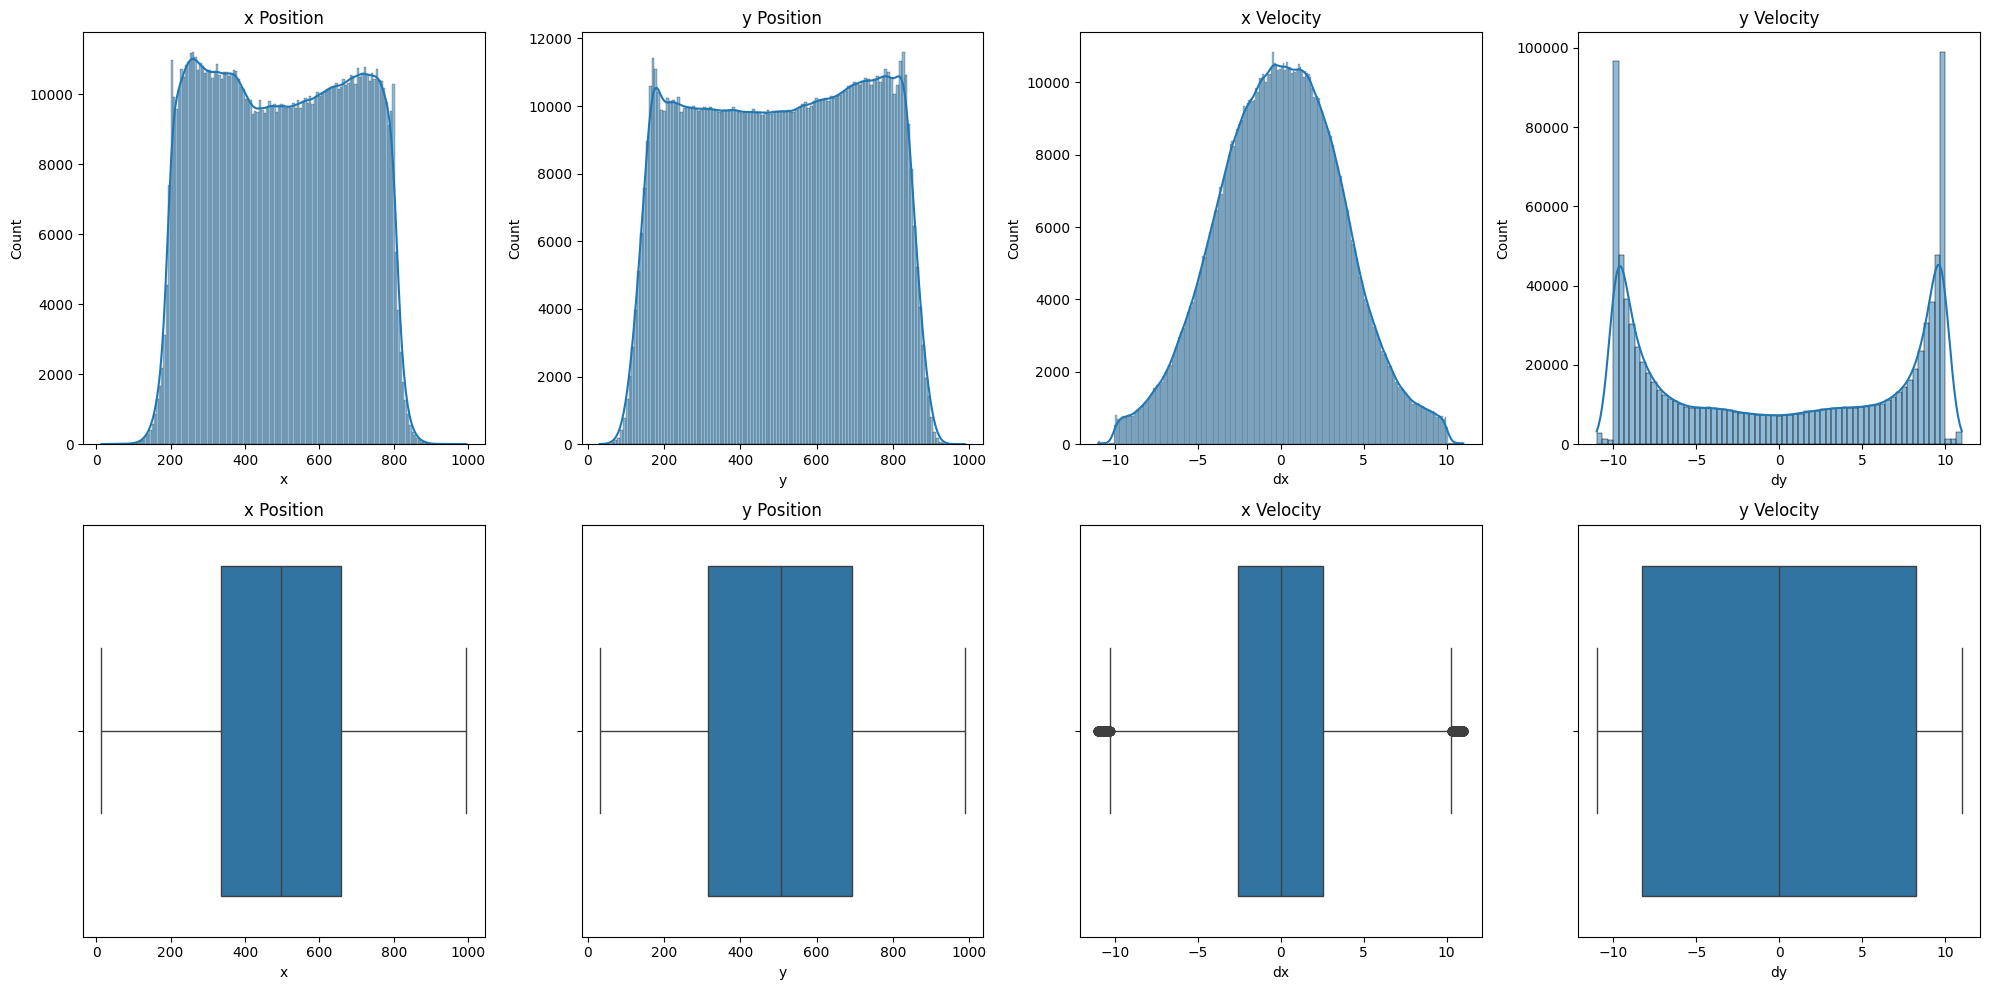

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Plot histograms
sns.histplot(sim_df['x'], ax=axes[0, 0], kde=True).set(title='x Position')
sns.histplot(sim_df['y'], ax=axes[0, 1], kde=True).set(title='y Position')
sns.histplot(sim_df['dx'], ax=axes[0, 2], kde=True).set(title='x Velocity')
sns.histplot(sim_df['dy'], ax=axes[0, 3], kde=True).set(title='y Velocity')

# Plot box plots
sns.boxplot(x=sim_df['x'], ax=axes[1, 0]).set(title='x Position')
sns.boxplot(x=sim_df['y'], ax=axes[1, 1]).set(title='y Position')
sns.boxplot(x=sim_df['dx'], ax=axes[1, 2]).set(title='x Velocity')
sns.boxplot(x=sim_df['dy'], ax=axes[1, 3]).set(title='y Velocity')

plt.tight_layout()
plt.show()


   Timestep  dx_variance  dy_variance
0         0     7.333602     9.331505
1         1     7.512673     8.849050
2         2     8.434200     9.154706
3         3    10.018720    10.486369
4         4    12.135720    12.481208


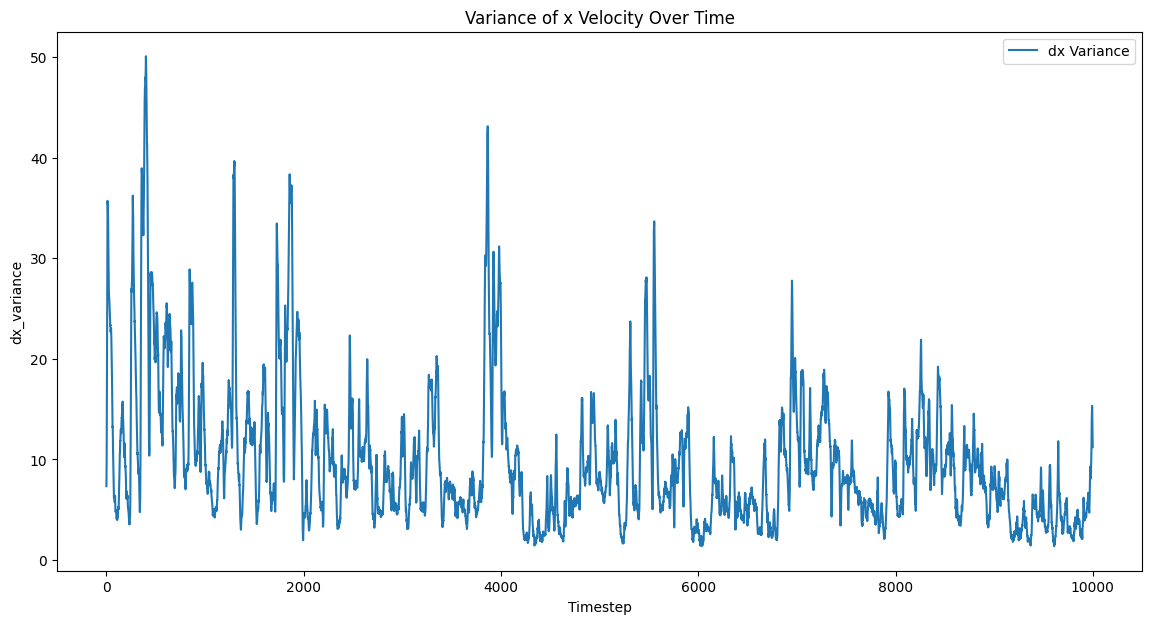

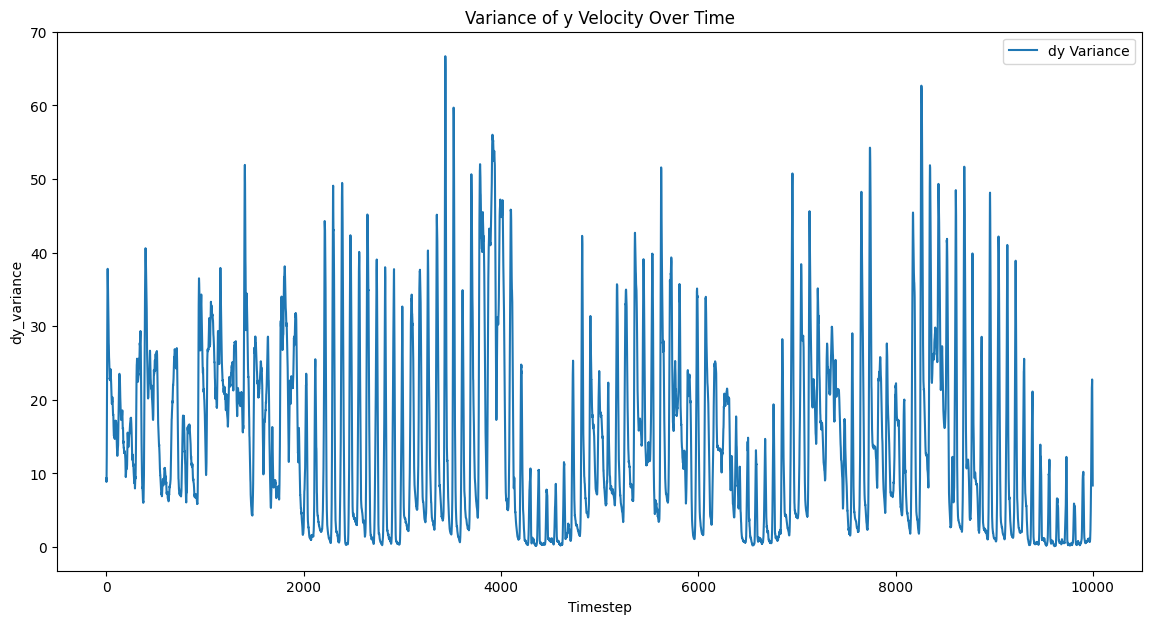

In [66]:
# Calculate variance of velocity
variance_df = sim_df.groupby('Timestep').agg({'dx': 'var', 'dy': 'var'}).reset_index()
variance_df.rename(columns={'dx': 'dx_variance', 'dy': 'dy_variance'}, inplace=True)

# Display the first few rows of the variance DataFrame
print(variance_df.head())

# Plot variance of velocity over time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.lineplot(data=variance_df, x='Timestep', y='dx_variance', label='dx Variance').set(title='Variance of x Velocity Over Time')

plt.figure(figsize=(14, 7))
sns.lineplot(data=variance_df, x='Timestep', y='dy_variance', label='dy Variance').set(title='Variance of y Velocity Over Time')

plt.show()


### EDA Of sim_edges_df

In [67]:
sim_edges_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10584262 entries, 0 to 10584261
Data columns (total 4 columns):
 #   Column      Dtype
---  ------      -----
 0   Boid_i      int64
 1   Boid_j      int64
 2   Timestep    int64
 3   Simulation  int64
dtypes: int64(4)
memory usage: 323.0 MB


In [68]:
sim_edges_df.isna()

,Boid_i,Boid_j,Timestep,Simulation
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
10584257,False,False,False,False
10584258,False,False,False,False
10584259,False,False,False,False
10584260,False,False,False,False


In [69]:
sim_edges_df.head()

,Boid_i,Boid_j,Timestep,Simulation
0,0,30,0,0
1,0,49,0,0
2,0,69,0,0
3,1,44,0,0
4,1,80,0,0


In [70]:
sim_edges_df.describe()

,Boid_i,Boid_j,Timestep,Simulation
count,1.058426e+07,1.058426e+07,1.058426e+07,10584262.0
mean,3.271459e+01,6.636189e+01,5.591884e+03,0.0
std,2.349444e+01,2.339839e+01,2.724393e+03,0.0
min,0.000000e+00,1.000000e+00,0.000000e+00,0.0
25%,1.300000e+01,5.000000e+01,3.576000e+03,0.0
50%,2.900000e+01,7.000000e+01,5.726000e+03,0.0
75%,4.900000e+01,8.600000e+01,7.912000e+03,0.0
max,9.800000e+01,9.900000e+01,9.999000e+03,0.0


### Converting DataFrame To Data Object From Pytorch Geometric

In [92]:
def toDataGraph(sim_df, sim_edges_df, node_features_names):
    """
    Converts simulation data into a PyTorch Geometric Data object.

    Parameters:
    - sim_df (DataFrame): DataFrame containing node features for a specific simulation and timestep.
    - sim_edges_df (DataFrame): DataFrame containing edge information for the simulation.
    - node_features_names (list of str): Names of the columns in sim_df that are node features.

    Returns:
    - Data: A PyTorch Geometric Data object representing the graph for the simulation.
    """
    # Convert node features and edge information into tensors
    node_features = torch.tensor(sim_df[node_features_names].to_numpy(), dtype=torch.float)
    edge_index = torch.tensor(sim_edges_df[['Boid_i', 'Boid_j']].to_numpy().T, dtype=torch.long)
    edge_attributes = torch.tensor(np.ones((sim_edges_df.shape[0], 1)), dtype=torch.float)

    # Create and return the Data object
    graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attributes)
    return graph

def allDataGraph(sim_df, sim_edges_df):
    """
    Generates a list of PyTorch Geometric Data objects for each simulation and timestep.

    Parameters:
    - sim_df (DataFrame): DataFrame containing node features for all simulations and timesteps.
    - sim_edges_df (DataFrame): DataFrame containing edge information for all simulations and timesteps.

    Returns:
    - list of Data: A list of PyTorch Geometric Data objects, one for each simulation and timestep.
    """
    # Group the data by simulation and timestep
    sim_gb_df = sim_df.groupby(['Timestep', 'Simulation'])
    sim_edges_gb_df = sim_edges_df.groupby(['Timestep', 'Simulation'])

    graphs = []
    # Iterate over each group and convert to a Data object
    # for key in sim_gb_df.groups.keys():
    #     curr_sim_df = sim_gb_df.get_group(key)
    #     curr_sim_edges_df = sim_edges_gb_df.get_group(key)
    #     curr_graph = toDataGraph(curr_sim_df, curr_sim_edges_df, ['x', 'y', 'dx', 'dy'])
    #     graphs.append(curr_graph)
    for key, _ in sim_gb_df:
        curr_sim_df = sim_gb_df.get_group(key)
        curr_sim_edges_df = sim_edges_gb_df.get_group(key)
        curr_graph = toDataGraph(curr_sim_df, curr_sim_edges_df, ['x', 'y', 'dx', 'dy'])
        graphs.append(curr_graph)

    return graphs

# Example usage
graphs = allDataGraph(sim_df, sim_edges_df)

In [93]:
## TODO: NEXT STEP MAKES CLASS THAT GIVEN THE SIMULATION DATAFRAME AND SIMULATION EDGES DATAFRAME CREATES A DATASET OBJECT

class CustomDataset(Dataset):
    def __init__(self, sim_df, sim_edges_df):
        super(CustomDataset).__init__()
        self.all_graphs = allDataGraph(sim_df, sim_edges_df)
        self.sequences = [graphs[i-5:i-1] for i in range(5, len(self.all_graphs)+1)]
        self.labels = [graphs[i-1] for i in range(5, len(self.all_graphs)+1)]
        self.len = len(self.labels)
    def __getitem__(self, index):
        return self.sequences[index], self.labels[index]
    def __len__(self):
        return self.len
    
dataset = CustomDataset(sim_df, sim_edges_df)

### test

In [94]:
# Create dataset and dataloader
# dataset = CustomDataset(sim_df, sim_edges_df)
batch_size = 1  # Adjust as needed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


In [95]:
import torch
from torch_geometric.data import Data

def toDataGraph(sim_df, sim_edges_df, node_features_names):
    node_features = torch.tensor(sim_df[node_features_names].to_numpy(), dtype=torch.float)
    edge_index = torch.tensor(sim_edges_df[['Boid_i', 'Boid_j']].to_numpy().T, dtype=torch.long)
    edge_attributes = torch.tensor(np.ones((sim_edges_df.shape[0], 1)), dtype=torch.float)
    graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attributes)
    return graph

def allDataGraph(sim_df, sim_edges_df):
    sim_gb_df = sim_df.groupby(['Timestep', 'Simulation'])
    sim_edges_gb_df = sim_edges_df.groupby(['Timestep', 'Simulation'])
    graphs = []
    for key in sim_gb_df.groups.keys():
        curr_sim_df = sim_gb_df.get_group(key)
        curr_sim_edges_df = sim_edges_gb_df.get_group(key)
        curr_graph = toDataGraph(curr_sim_df, curr_sim_edges_df, ['x', 'y', 'dx', 'dy'])
        graphs.append(curr_graph)
    return graphs


In [96]:
# class RNNModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
#         super(RNNModel, self).__init__()
#         self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         out, _ = self.rnn(x)
#         out = self.fc(out[:, -1, :])
#         return out

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out
    
# Model parameters
input_dim = 4  # 'x', 'y', 'dx', 'dy'
hidden_dim = 10
output_dim = 4  # Predicting 'x', 'y', 'dx', 'dy'
num_layers = 1

# model = RNNModel(input_dim, hidden_dim, output_dim, num_layers)
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)



In [97]:

# Training parameters
num_epochs = 50
learning_rate = 0.0001

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    for sequences, labels in dataloader:
        optimizer.zero_grad()
        loss = 0
        for seq in sequences:
            seq_x = seq.x.view(seq.num_graphs, -1, input_dim)
            outputs = model(seq_x)
            # Assuming labels are the positions to predict, and we use only 'x' and 'y' for output
            labels_x = labels.x.view(labels.num_graphs, -1, output_dim)[:, -1, :]  # Last position
            loss += criterion(outputs, labels_x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


/opt/anaconda3/envs/aiml2/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss: 144124.0318
Epoch [2/50], Loss: 141620.6015
Epoch [3/50], Loss: 139094.9337
Epoch [4/50], Loss: 136605.0771
Epoch [5/50], Loss: 134146.9757
Epoch [6/50], Loss: 131713.7067
Epoch [7/50], Loss: 129313.7792
Epoch [8/50], Loss: 126944.2970
Epoch [9/50], Loss: 124066.4909
Epoch [10/50], Loss: 121339.8629
Epoch [11/50], Loss: 118972.3091
Epoch [12/50], Loss: 116638.5003
Epoch [13/50], Loss: 114335.2080
Epoch [14/50], Loss: 112064.7786
Epoch [15/50], Loss: 109827.8513
Epoch [16/50], Loss: 107624.0330
Epoch [17/50], Loss: 105448.2702
Epoch [18/50], Loss: 103308.6941
Epoch [19/50], Loss: 101199.2858
Epoch [20/50], Loss: 99121.7803
Epoch [21/50], Loss: 97072.8965
Epoch [22/50], Loss: 95063.0580
Epoch [23/50], Loss: 93079.9470
Epoch [24/50], Loss: 91129.6613
Epoch [25/50], Loss: 89210.8108
Epoch [26/50], Loss: 87322.8545
Epoch [27/50], Loss: 85468.4052
Epoch [28/50], Loss: 83642.5836
Epoch [29/50], Loss: 81850.0397
Epoch [30/50], Loss: 80085.3356
Epoch [31/50], Loss: 78354.290

In [99]:
# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():
        for sequences, labels in dataloader:
            loss = 0
            for seq in sequences:
                seq_x = seq.x.view(seq.num_graphs, -1, input_dim)
                outputs = model(seq_x)
                labels_x = labels.x.view(labels.num_graphs, -1, output_dim)[:, -1, :]  # Last position
                loss += criterion(outputs, labels_x)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f'Average Loss: {avg_loss:.4f}')

# Evaluate the model
evaluate_model(model, dataloader)


/opt/anaconda3/envs/aiml2/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([4, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Loss: 50680.6376
